<a href="https://colab.research.google.com/github/rkhamilton/vqgan-clip-generator/blob/main/vqgan_clip_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VQGAN_CLIP_GENERATOR**
Documentation is provided at [the project home page](https://github.com/rkhamilton/vqgan-clip-generator).

Implements VQGAN+CLIP for image and video generation, and style transfers, based on text and image prompts. Emphasis on ease-of-use, documentation, and smooth video creation.

This package is compatible with all of the usual trained models that work with VQGAN (sflickr, coco, etc). Code is provided here only for ImageNet for simplicity.

In [ ]:
#@title MIT License
# 

# Copyright (c) 2021 Ryan Hamilton

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [1]:
#@markdown What GPU am I using?

#@markdown V100 > P100 > everything else

!nvidia-smi --query-gpu=gpu_name,memory.total,gpu_bus_id,vbios_version --format=csv
gpu_name = !nvidia-smi --query-gpu=gpu_name, --format=csv

name, memory.total [MiB], pci.bus_id, vbios_version
Tesla K80, 11441 MiB, 00000000:00:04.0, 80.21.25.00.01


# **Filesystem Setup**
Run **one** of the Filesystem blocks below to set your root location.

In [1]:
#@title Use Google Drive as your Filesystem
#@markdown This option connects to your google drive, and saves model files and outputs to that location for re-use.
import os
abs_root_path = "/content"

from google.colab import drive
drive.mount('/content/drive')

def ensureProperRootPath():
    if len(abs_root_path) > 0:
        os.chdir(abs_root_path) # Changes directory to absolute root path
        print("Root path check: ")
        !pwd

ensureProperRootPath()

def make_folder(folder_name):
  if len(folder_name) > 0:
      path_tmp = os.path.join("/content/drive/MyDrive/",folder_name)
      if not os.path.exists(path_tmp):
          os.mkdir(path_tmp)
      return path_tmp


project_folder_name = "VQGAN_CLIP_GENERATOR" #@param {type: "string"}
abs_root_path = make_folder(project_folder_name)

print("Created folder & set root path to: " + abs_root_path)
%cd $abs_root_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root path check: 
/content
Created folder & set root path to: /content/drive/MyDrive/VQGAN_CLIP_GENERATOR
/content/drive/MyDrive/VQGAN_CLIP_GENERATOR


In [ ]:
#@title Use Local Google Colab Filesystem
#@markdown If you use the local google filesystem, all data will be lost at the
#@markdown end of the session. VQGAN models will have to be re-downloaded.
import os
abs_root_path = "/content"
def ensureProperRootPath():
    if len(abs_root_path) > 0:
        os.chdir(abs_root_path) # Changes directory to absolute root path
        print("Root path check: ")
        !pwd

ensureProperRootPath()
print("Your root directory is: ")
!pwd

def make_folder(folder_name):
  abs_root_path = "/content"
  if len(folder_name) > 0:
      path_tmp = abs_root_path + "/drive/MyDrive/" + folder_name
      if not os.path.exists(path_tmp):
          os.mkdir(path_tmp)
      return path_tmp
%cd $abs_root_path

# **Download Dependencies for Google Colab**

In [ ]:
#@title Download dependencies
#@markdown Needed every time you connect to a fresh colab runtime.
! pip install torch_optimizer==0.1.0
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/rkhamilton/vqgan-clip-generator.git
!pip install opencv-python scipy
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install git+https://github.com/xinntao/Real-ESRGAN
!pip install sk-video
!pip install opencv-python
!pip install moviepy

In [46]:
#@title Download RIFE and pre-trained model
#@markdown Only needed once for initial setup to download this pacakge to your Google Drive.
!git clone https://github.com/hzwer/arXiv2020-RIFE
import os
os.makedirs(f'arXiv2020-RIFE/train_log',exist_ok=True)
!curl -L -o 'arXiv2020-RIFE/RIFE_trained_model_v3.8.zip' -C - 'https://drive.google.com/u/0/uc?id=1O5KfS3KzZCY3imeCr2LCsntLhutKuAqj&export=download'
!unzip 'arXiv2020-RIFE/RIFE_trained_model_v3.8.zip' -d arXiv2020-RIFE

** Resuming transfer from byte position 11320498
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388  100   388    0     0    751      0 --:--:-- --:--:-- --:--:--   751
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
Archive:  arXiv2020-RIFE/RIFE_trained_model_v3.8.zip
replace arXiv2020-RIFE/train_log/flownet.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: arXiv2020-RIFE/train_log/flownet.pkl  
replace arXiv2020-RIFE/train_log/IFNet_HDv3.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace arXiv2020-RIFE/train_log/IFNet_HDv3.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: arXiv2020-RIFE/train_log/IFNet_HDv3.py  
  inflating: arXiv2020-RIFE/train_log/RIFE_HDv3.py  


# **Define Paths and Import libraries**

In [2]:
#@title Run this once every time you reset your runtime.
import os
extracted_video_frames_dir = os.path.join(abs_root_path, "extracted_video_frames")
generated_video_frames_path = os.path.join(abs_root_path, "generated_video_frames")
upscaled_video_frames_path = os.path.join(abs_root_path, "upscaled_video_frames")

output_dir = os.path.join(abs_root_path, "output")
models_dir = os.path.join(abs_root_path, "models")

make_folder(extracted_video_frames_dir)
make_folder(generated_video_frames_path)
make_folder(upscaled_video_frames_path)
make_folder(output_dir)
make_folder(models_dir)

print(f'output_dir:\t\t\t{output_dir}')
print(f'generated_video_frames_path:\t{generated_video_frames_path}')
print(f'extracted_video_frames_dir:\t{extracted_video_frames_dir}')
print(f'upscaled_video_frames_path:\t{upscaled_video_frames_path}')
print(f'models_dir:\t\t\t{models_dir}')

from vqgan_clip import generate, video_tools, esrgan
from vqgan_clip.engine import VQGAN_CLIP_Config
import os
from IPython import display
import subprocess

output_dir:			/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output
generated_video_frames_path:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/generated_video_frames
extracted_video_frames_dir:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/extracted_video_frames
upscaled_video_frames_path:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/upscaled_video_frames
models_dir:			/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/models


# **Generate Images and Video**

# **Generate a single image from a prompt**

single image:   0%|          | 0/10 [00:00<?, ?iteration/s]

/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/my_image.png


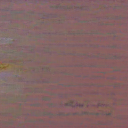

In [6]:
#@title Generate the image
config = VQGAN_CLIP_Config()
config.model_dir = models_dir
output_image_width_pixels = 128 #@param {type: "integer"}
output_image_height_pixels = 128 #@param {type: "integer"}
config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
text_prompts = 'A pastoral landscape painting by Rembrandt' #@param {type: "string"}
iterations = 100 #@param {type: "integer"}

output_filename = os.path.join(output_dir,'my_image.png')
generate.image(eng_config = config,
        text_prompts = text_prompts,
        iterations = iterations,
        output_filename = output_filename)

print(output_filename)
display.display(display.Image(output_filename))

Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/models/RealESRGAN_x4plus.pth



  0%|          | 0.00/63.9M [00:00<?, ?B/s]

Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /usr/local/lib/python3.7/dist-packages/facexlib/weights/detection_Resnet50_Final.pth



  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth" to /usr/local/lib/python3.7/dist-packages/gfpgan/weights/GFPGANCleanv1-NoCE-C2.pth



  0%|          | 0.00/332M [00:00<?, ?B/s]

Real-ESRGAN:   0%|          | 0/1 [00:00<?, ?image/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Real-ESRGAN: 100%|██████████| 1/1 [00:01<00:00,  1.40s/image]

/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/my_image_upscaled.png


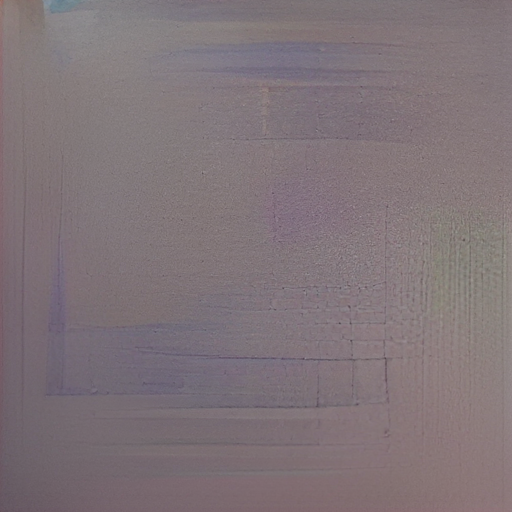

In [6]:
#@title Upscale the image
esrgan.inference_realesrgan(input=output_filename,
        output_images_path=output_dir,
        model_dir=models_dir,
        face_enhance=False)

upscaled_filename = os.path.splitext(output_filename)[0] + '_upscaled.png'
print(upscaled_filename)
display.display(display.Image(upscaled_filename))

# **Generate a zoom video**

In [3]:
#@title Setup paths and parameters
#@markdown Generate a video with movement. Every frame that is generated has a shift or zoom applied to it.
#@markdown This gives the appearance of motion in the result.
#@markdown This is one of the most interesting application of VQGAN+CLIP here.

config = VQGAN_CLIP_Config()
config.model_dir=models_dir
text_prompts = 'A pastoral landscape painting by Rembrandt | wolves chasing sheep' #@param {type: "string"}
output_image_width_pixels = 128 #@param {type: "integer"}
output_image_height_pixels = 128 #@param {type: "integer"}
config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
num_video_frames = 150 #@param {type: "integer"}
iterations_per_frame = 15 #@param {type: "integer"}
change_prompts_on_frame= [60, 100] #@param {type: "raw"}
video_framerate=30  #@param {type: "integer"}
zoom_scale=1.02  #@param {type: "number"}
shift_x=1 #@param {type: "integer"}
shift_y=1 #@param {type: "integer"}
final_video_filename = 'zoom_video.mp4' #@param {type: "string"}

output_file_path = os.path.join(output_dir, final_video_filename)
init_image = os.path.join(output_dir,'init_image.png')
video_frames_to_encode = generated_video_frames_path
# This will be overwritten when we create the video
metadata_comment = ''

In [ ]:
#@title Generate a zoom video
# Generate an initial image to seed the video, otherwise the video will start with a gray field.
generate.image(eng_config = config,
        text_prompts = text_prompts,
        iterations = 30,
        output_filename = init_image)

# Generate a zoom video starting from that initial frame.
metadata_comment = generate.video_frames(num_video_frames=num_video_frames,
        eng_config = config,
        text_prompts = text_prompts,
        init_image = init_image,
        generated_video_frames_path = generated_video_frames_path,
        iterations_per_frame = iterations_per_frame,
        change_prompts_on_frame= change_prompts_on_frame,
        zoom_scale=zoom_scale, 
        shift_x=shift_x, 
        shift_y=shift_y,
        z_smoother=True,
        z_smoother_buffer_len=5,
        z_smoother_alpha=0.9)

In [11]:
#@title Upscale the video frames
esrgan.inference_realesrgan(input=generated_video_frames_path,
                            output_images_path=upscaled_video_frames_path,
                            face_enhance=False,
                            model_dir=models_dir,
                            purge_existing_files=True,
                            model_filename='RealESRGAN_x4plus_anime_6B.pth',
                            model_url='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth',
                            netscale=4,
                            outscale=4)
video_frames_to_encode = upscaled_video_frames_path

Real-ESRGAN:   0%|          | 0/15 [00:00<?, ?image/s]

In [4]:
#@title Encode the video frames to MP4
video_tools.encode_video(output_file=output_file_path,
                         path_to_stills=video_frames_to_encode,
                         metadata_title=text_prompts,
                         metadata_comment=metadata_comment,
                         input_framerate=video_framerate)

FFMPEG command used was:
ffmpeg -y -f image2 -r 30 -i /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/generated_video_frames/frame_%12d.png -r 30 -vcodec libx264 -crf 23 -pix_fmt yuv420p -hide_banner -loglevel error -metadata title="A pastoral landscape painting by Rembrandt | wolves chasing sheep" -metadata comment="" -metadata description="Generated with https://github.com/rkhamilton/vqgan-clip-generator" /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/zoom_video.mp4


In [5]:
#@title Use optical flow interpolation with RIFE
video_tools.RIFE_interpolation(input=output_file_path,
                    output=f'{os.path.splitext(output_file_path)[0]}_RIFE.mp4',
                    interpolation_factor=4,
                    metadata_title=text_prompts,
                    metadata_comment=metadata_comment)

# **Style transfer to an existing video**

In [6]:
#@title Setup paths and parameters
#@markdown An existing video will have a VQGAN style applied to each frame.
#@markdown Refer to the [documentation](https://github.com/rkhamilton/vqgan-clip-generator/blob/main/README.md) 
#@markdown for an explanation of the options.

config = VQGAN_CLIP_Config()
config.model_dir = models_dir
input_video_path = 'small.mp4' #@param {type: "string"}
output_video_filename = 'style_transfer_video.mp4' #@param {type: "string"}
extraction_framerate = 1 #@param {type: "integer"}
text_prompts = 'portrait on deviantart' #@param {type: "string"}
change_prompts_on_frame= [60, 100] #@param {type: "raw"}
output_image_width_pixels = 128 #@param {type: "integer"}
output_image_height_pixels = 128 #@param {type: "integer"}
iterations_per_frame = 5 #@param {type: "integer"}
change_prompts_on_frame = [70, 150]  #@param {type: "raw"}
#@markdown Effects how closely the output video will be to the source video image. Values of 0.5-8.0 are reasonable.
current_source_frame_image_weight = 2.0 #@param {type: "number"}
#@markdown Effects how closely the output video will be to the source video content. Values of 0.0-1.0 are reasonable.
current_source_frame_prompt_weight=0.5 #@param {type: "number"}

config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
init_image = f'{output_dir}{os.sep}init_image.png'
output_video_path = f'{output_dir}{os.sep}{output_video_filename}'
video_frames_to_encode = generated_video_frames_path
metadata_comment = ''
generated_video_no_audio=f'{output_dir}{os.sep}output_no_audio.mp4'

In [20]:
#@title Extract frames from your source video
original_video_frames = video_tools.extract_video_frames(input_video_path, 
        extraction_framerate = extraction_framerate,
        extracted_video_frames_path=extracted_video_frames_dir)

In [ ]:
#@title Apply a style to the extracted video frames.
metadata_comment = generate.style_transfer(original_video_frames,
                                           eng_config=config,
                                           current_source_frame_image_weight=current_source_frame_image_weight,
                                           current_source_frame_prompt_weight=current_source_frame_prompt_weight,
                                           text_prompts=text_prompts,
                                           iterations_per_frame=iterations_per_frame,
                                           change_prompts_on_frame=change_prompts_on_frame,
                                           generated_video_frames_path=generated_video_frames_path,
                                           z_smoother=True,
                                           z_smoother_alpha=0.9,
                                           z_smoother_buffer_len=3)

In [21]:
#@title Upscale the styled video frames using Real-ESRGAN
face_enhance = False #@param {type: "boolean"}
esrgan.inference_realesrgan(input=generated_video_frames_path,
        output_images_path=upscaled_video_frames_path,
        face_enhance=face_enhance,
        purge_existing_files=True,
        model_dir=models_dir)
video_frames_to_encode = upscaled_video_frames_path

Real-ESRGAN:   0%|          | 0/42 [00:00<?, ?image/s]

In [7]:
#@title Use a wrapper for FFMPEG to encode the images into a video
video_tools.encode_video(output_file=output_video_path,
        path_to_stills=video_frames_to_encode,
        metadata_title=text_prompts,
        metadata_comment=metadata_comment,
        input_framerate=extraction_framerate)

FFMPEG command used was:
ffmpeg -y -f image2 -r 1 -i /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/generated_video_frames/frame_%12d.png -r 1 -vcodec libx264 -crf 23 -pix_fmt yuv420p -hide_banner -loglevel error -metadata title="portrait on deviantart" -metadata comment="" -metadata description="Generated with https://github.com/rkhamilton/vqgan-clip-generator" /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/style_transfer_video.mp4


In [8]:
#@title Copy audio from the original video into your generated video (optional)
tempfile = f'{output_dir}{os.sep}temp.mp4'
video_tools.copy_video_audio(input_video_path, output_video_path, tempfile)
if os.path.exists(tempfile):
  os.remove(output_video_path)
  os.rename(tempfile,output_video_path)

FFMPEG command used was:
ffmpeg -i small.mp4 -vn -acodec copy -hide_banner -loglevel error /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/extracted_original_audio.aac
FFMPEG command used was:
ffmpeg -i /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/style_transfer_video.mp4 -i /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/extracted_original_audio.aac -c copy -map 0:v:0 -map 1:a:0 -hide_banner -loglevel error /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/temp.mp4


In [9]:
#@title Use optical flow interpolation with RIFE
#@markdown This creates a separate video with '_RIFE' at the end of the filename.
video_tools.RIFE_interpolation(input=output_video_path,
                    output=f'{os.path.splitext(output_video_path)[0]}_RIFE.mp4',
                    interpolation_factor=4,
                    metadata_title=text_prompts,
                    metadata_comment=metadata_comment)

In [ ]:
#@title Download video from Google Colab using the browser
#@markdown If you are using the Google Drive filesystem, the file is already 
#@markdown stored there. Running this block lets you download it through your browser.
from google.colab import files
files.download(output_video_path)